In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [5]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [6]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

In [7]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

In [8]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

In [9]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

In [10]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2024-10-30 07:52:36,158	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.72gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

In [107]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

In [108]:
def crop_roi(self, image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = tf.cast(img_shape[0], tf.float32)
    img_width = tf.cast(img_shape[1], tf.float32)

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.float32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.float32)
    center_x = tf.cast(features['image/object/center/x'], dtype=tf.float32)
    center_y = tf.cast(features['image/object/center/y'], dtype=tf.float32)
    body_height = tf.cast(features['image/object/scale'], dtype=tf.float32) * 200.0
    
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
    
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)
    
    xmin = keypoint_xmin - body_height * margin
    xmax = keypoint_xmax + body_height * margin
    ymin = keypoint_ymin - body_height * margin
    ymax = keypoint_ymax + body_height * margin
    
    effective_xmin = tf.clip_by_value(xmin, 0.0, img_width)
    effective_ymin = tf.clip_by_value(ymin, 0.0, img_height)
    effective_xmax = tf.clip_by_value(xmax, 0.0, img_width)
    effective_ymax = tf.clip_by_value(ymax, 0.0, img_height)

    # 이미지 자르기
    cropped_image = image[tf.cast(effective_ymin, tf.int32):tf.cast(effective_ymax, tf.int32),
                          tf.cast(effective_xmin, tf.int32):tf.cast(effective_xmax, tf.int32), :]

    new_height = tf.cast(tf.shape(cropped_image)[0], tf.float32)
    new_width = tf.cast(tf.shape(cropped_image)[1], tf.float32)

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return cropped_image, effective_keypoint_x, effective_keypoint_y

In [109]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

In [182]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])
        
        # 이미지 크기 확인
        print(f"Image shape after decoding: {image.shape}")

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        # 이미지 정규화 및 크기 확인
        image = tf.cast(image, tf.float32) / 127.5 - 1
        print(f"Image shape after resizing and normalization: {image.shape}")

        # 히트맵 생성 및 크기 확인
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)
        print(f"Generated heatmaps shape: {heatmaps.shape}")

        return image, heatmaps
    
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = tf.cast(img_shape[0], tf.float32)
        img_width = tf.cast(img_shape[1], tf.float32)

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.float32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.float32)
        center_x = tf.cast(features['image/object/center/x'], dtype=tf.float32)
        center_y = tf.cast(features['image/object/center/y'], dtype=tf.float32)
        body_height = tf.cast(features['image/object/scale'], dtype=tf.float32) * 200.0

        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)

        xmin = keypoint_xmin - body_height * margin
        xmax = keypoint_xmax + body_height * margin
        ymin = keypoint_ymin - body_height * margin
        ymax = keypoint_ymax + body_height * margin

        effective_xmin = tf.clip_by_value(xmin, 0.0, img_width)
        effective_ymin = tf.clip_by_value(ymin, 0.0, img_height)
        effective_xmax = tf.clip_by_value(xmax, 0.0, img_width)
        effective_ymax = tf.clip_by_value(ymax, 0.0, img_height)

        # 이미지 자르기
        cropped_image = image[tf.cast(effective_ymin, tf.int32):tf.cast(effective_ymax, tf.int32),
                              tf.cast(effective_xmin, tf.int32):tf.cast(effective_xmax, tf.int32), :]

        new_height = tf.cast(tf.shape(cropped_image)[0], tf.float32)
        new_width = tf.cast(tf.shape(cropped_image)[1], tf.float32)

        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

        return cropped_image, effective_keypoint_x, effective_keypoint_y

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example, image_feature_description)

    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, size=num_heatmap)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_gaussian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # (64, 64, 16)
        
        return heatmaps

    def generate_2d_gaussian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        # 모든 변수를 float32로 변환하여 일관성 유지
        height = tf.cast(height, tf.float32)
        width = tf.cast(width, tf.float32)
        y0 = tf.cast(y0, tf.float32)
        x0 = tf.cast(x0, tf.float32)
        sigma = tf.cast(sigma, tf.float32)
        scale = tf.cast(scale, tf.float32)

        heatmap = tf.zeros((tf.cast(height, tf.int32), tf.cast(width, tf.int32)), dtype=tf.float32)

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
            return heatmap

        size = tf.cast(6 * sigma + 1, tf.int32)
        x, y = tf.meshgrid(tf.range(0, size, 1, dtype=tf.float32), tf.range(0, size, 1, dtype=tf.float32), indexing='xy')

        center_x = tf.cast(size // 2, tf.float32)
        center_y = tf.cast(size // 2, tf.float32)

        gaussian_patch = tf.exp(-(tf.square(x - center_x) + tf.square(y - center_y)) / (2 * sigma ** 2)) * scale

        patch_xmin = tf.maximum(0, tf.cast(-xmin, tf.int32))
        patch_ymin = tf.maximum(0, tf.cast(-ymin, tf.int32))
        patch_xmax = tf.minimum(tf.cast(xmax, tf.int32), tf.cast(width, tf.int32)) - tf.cast(xmin, tf.int32)
        patch_ymax = tf.minimum(tf.cast(ymax, tf.int32), tf.cast(height, tf.int32)) - tf.cast(ymin, tf.int32)

        heatmap_xmin = tf.maximum(0, tf.cast(xmin, tf.int32))
        heatmap_ymin = tf.maximum(0, tf.cast(ymin, tf.int32))
        heatmap_xmax = tf.minimum(tf.cast(xmax, tf.int32), tf.cast(width, tf.int32))
        heatmap_ymax = tf.minimum(tf.cast(ymax, tf.int32), tf.cast(height, tf.int32))

        indices = tf.TensorArray(tf.int32, size=1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1

        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


In [183]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

In [184]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

In [185]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

In [186]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

In [187]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = tf.constant(0.0, dtype=tf.float32) # float32 타입으로 초기화
        labels = tf.cast(labels, dtype=tf.float32) # labels를 float32로 변환

        for output in outputs:
            output = tf.cast(output, dtype=tf.float32) # output을 float32로 변환
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
            tf.math.square(labels - output) * weights) * (
                1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [200]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords_pattern, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)
    tfrecord_files = tf.io.gfile.glob(tfrecords_pattern)
    
    if not tfrecord_files:
        raise ValueError(f"{'Train' if is_train else 'Validation'} dataset TFRecord files not found.")
    
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    # 데이터셋이 비어 있는지 확인
    num_elements = tf.data.experimental.cardinality(dataset).numpy()
    if num_elements <= 0:
        raise ValueError(f"{'Train' if is_train else 'Validation'} dataset is empty after processing.")
    print(f"{'Train' if is_train else 'Validation'} dataset size: {num_elements} batches")
    
    return dataset

In [189]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [190]:
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

In [191]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [192]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

In [193]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

In [194]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [195]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

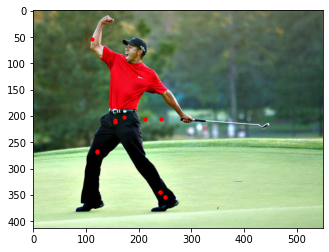

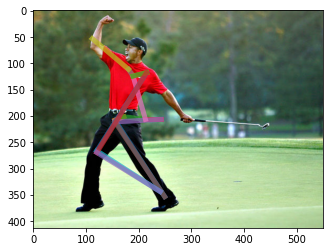

In [196]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

In [197]:
import tensorflow as tf
import numpy as np
import PIL
import ray

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(ray.__version__)

2.6.0
1.21.4
8.3.2
1.7.0


# simplebaseline 모델로 변경해 봅시다
- 지금까지 우리는 StackedHourglass Network 기반으로 학습을 진행해 왔습니다.
- 그러나 지난 시간에 살펴본 것처럼 Simplebaseline 모델은 이보다 훨씬 간단한 모델 구조에도 불구하고 더욱 좋은 성능을 보여주었던 바 있습니다.
- 실제로도 그런 성능을 얻을 수 있을지 확인해 보겠습니다.

# STEP 1 : simplebaseline 모델 완성하기
- simplebaseline.py 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성합니다.

In [198]:
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

upconv1 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn1 = tf.keras.layers.BatchNormalization()
relu1 = tf.keras.layers.ReLU()
upconv2 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn2 = tf.keras.layers.BatchNormalization()
relu2 = tf.keras.layers.ReLU()
upconv3 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn3 = tf.keras.layers.BatchNormalization()
relu3 = tf.keras.layers.ReLU()

def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

upconv = _make_deconv_layer(3)

final_layer = tf.keras.layers.Conv2D(16, kernel_size=(1,1), padding='same')

inputs = keras.Input(shape=(256, 256, 3))
x = resnet(inputs)
x = upconv(x)
out = final_layer(x)
model = keras.Model(inputs, out)

model.summary()

np_input = np.zeros((1,256, 256,3), dtype=np.float32)
tf_input = tf.convert_to_tensor(np_input, dtype=tf.float32)
print('input shape')
print (tf_input.shape)
print('\n')

tf_output = model(tf_input)
print('output shape')
print (tf_output.shape)
print (tf_output[0,:10,:10,:10])

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential_12 (Sequential)   (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d_2452 (Conv2D)         (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________
input shape
(1, 256, 256, 3)


output shape
(1, 64, 64, 16)
tf.Tensor(
[[[ 1.68117287e-03 -5.75346546e-03 -8.49482697e-03  2.57680146e-03
    2.50288192e-03 -9.73148458e-03 -1.07353786e-03  5.88416355e-03
   -4.22637677e-03 -4.66450956e-03

# STEP 2 : simplebaseline 모델로 변경하여 훈련하기
- StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행합니다.

In [202]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

# 모델 저장 경로 설정
MODEL_PATH = os.path.join('/aiffel/tmp', 'models')
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

# SimpleBaseline 모델 생성 함수
def create_simplebaseline_model(input_shape=(256, 256, 3), num_heatmap=16):
    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
    upconv = tf.keras.models.Sequential()
    for _ in range(3):
        upconv.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        upconv.add(tf.keras.layers.BatchNormalization())
        upconv.add(tf.keras.layers.ReLU())
    final_layer = tf.keras.layers.Conv2D(num_heatmap, kernel_size=(1, 1), padding='same')
    inputs = keras.Input(shape=input_shape)
    x = resnet(inputs)
    x = upconv(x)
    outputs = final_layer(x)
    return keras.Model(inputs, outputs)

# 학습 준비 함수
def prepare_for_training(model, learning_rate=0.001):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mse',
                  metrics=['accuracy'])
    return model

# 데이터셋 생성 함수 (기존 데이터셋 함수 활용)
def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)
    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)  # 적절한 버퍼 사이즈로 설정
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

def train_model(model, train_dataset, val_dataset, epochs):
    checkpoint_path = os.path.join(MODEL_PATH, 'simplebaseline_epoch_{epoch:02d}_loss_{val_loss:.4f}.h5')
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')
    
    model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[checkpoint])

# 데이터셋 생성 함수 (기존 데이터셋 함수 활용)
def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)
    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    # 데이터셋이 비어 있는지 확인
    num_elements = tf.data.experimental.cardinality(dataset).numpy()
    if num_elements == 0:
        raise ValueError(f"{'Train' if is_train else 'Validation'} dataset is empty after processing.")
    print(f"{'Train' if is_train else 'Validation'} dataset size: {num_elements} batches")
    
    return dataset

if __name__ == "__main__":
    # 설정
    EPOCHS = 5
    LEARNING_RATE = 0.001
    NUM_HEATMAP = 16
    BATCH_SIZE = 8
    TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')

    # 데이터셋 로드
    train_tfrecords = os.path.join(TFRECORD_PATH, 'train_*.tfrecords')
    val_tfrecords = os.path.join(TFRECORD_PATH, 'val_*.tfrecords')
    
    # 데이터셋 생성 및 디버깅
    print("Creating training dataset...")
    train_dataset = create_dataset(train_tfrecords, BATCH_SIZE, NUM_HEATMAP, is_train=True)
    print("Creating validation dataset...")
    val_dataset = create_dataset(val_tfrecords, BATCH_SIZE, NUM_HEATMAP, is_train=False)

    # SimpleBaseline 모델 학습
    print("Training SimpleBaseline Model")
    simplebaseline_model = create_simplebaseline_model(input_shape=IMAGE_SHAPE, num_heatmap=NUM_HEATMAP)
    simplebaseline_model = prepare_for_training(simplebaseline_model, LEARNING_RATE)
    train_model(simplebaseline_model, train_dataset, val_dataset, EPOCHS)

Creating training dataset...
Image shape after decoding: (None, None, None)
Image shape after resizing and normalization: (256, 256, None)
Generated heatmaps shape: (64, 64, 16)
Train dataset size: -2 batches
Creating validation dataset...
Image shape after decoding: (None, None, None)
Image shape after resizing and normalization: (256, 256, None)
Generated heatmaps shape: (64, 64, 16)
Validation dataset size: -2 batches
Training SimpleBaseline Model
Epoch 1/5
2776/2776 [==============================] - 851s 293ms/step - loss: 0.0982 - accuracy: 0.0862 - val_loss: 0.0903 - val_accuracy: 0.1121


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
2776/2776 [==============================] - 836s 289ms/step - loss: 0.0843 - accuracy: 0.1192 - val_loss: 0.0832 - val_accuracy: 0.0975
Epoch 3/5
2776/2776 [==============================] - 850s 293ms/step - loss: 0.0789 - accuracy: 0.1273 - val_loss: 0.0776 - val_accuracy: 0.1010
Epoch 4/5
2776/2776 [==============================] - 828s 286ms/step - loss: 0.0759 - accuracy: 0.1345 - val_loss: 0.0768 - val_accuracy: 0.1549
Epoch 5/5
2776/2776 [==============================] - 818s 284ms/step - loss: 0.0732 - accuracy: 0.1381 - val_loss: 0.0738 - val_accuracy: 0.0880


# STEP 3 : 두 모델의 비교
- 실습에서 다룬 StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교해 봅니다.
    - Pose Estimation 결과 시각화 (정성적 비교)
    - 학습 진행 경과 (loss 감소 현황)
- 가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다.

Training StackedHourglass Model
Epoch 1/5
2776/2776 [==============================] - 1321s 457ms/step - loss: 0.4182 - conv2d_2767_loss: 0.1090 - conv2d_2825_loss: 0.1048 - conv2d_2883_loss: 0.1027 - conv2d_2941_loss: 0.1017 - conv2d_2767_accuracy: 0.0825 - conv2d_2825_accuracy: 0.1008 - conv2d_2883_accuracy: 0.1148 - conv2d_2941_accuracy: 0.1164 - val_loss: 0.3993 - val_conv2d_2767_loss: 0.1016 - val_conv2d_2825_loss: 0.0999 - val_conv2d_2883_loss: 0.0990 - val_conv2d_2941_loss: 0.0987 - val_conv2d_2767_accuracy: 0.0885 - val_conv2d_2825_accuracy: 0.1040 - val_conv2d_2883_accuracy: 0.1197 - val_conv2d_2941_accuracy: 0.0941
Epoch 2/5
2776/2776 [==============================] - 1299s 457ms/step - loss: 0.3841 - conv2d_2767_loss: 0.0996 - conv2d_2825_loss: 0.0959 - conv2d_2883_loss: 0.0944 - conv2d_2941_loss: 0.0942 - conv2d_2767_accuracy: 0.1017 - conv2d_2825_accuracy: 0.0996 - conv2d_2883_accuracy: 0.1150 - conv2d_2941_accuracy: 0.1198 - val_loss: 0.3710 - val_conv2d_2767_loss: 0.09

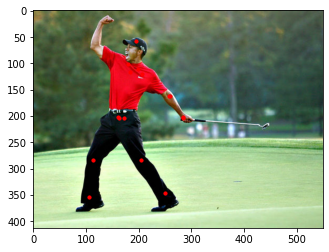

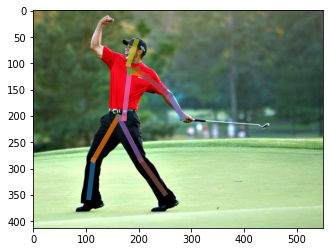

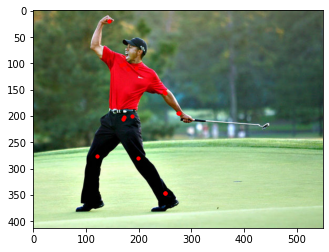

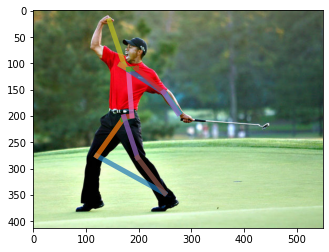

In [206]:
# Step 3: StackedHourglass 모델 학습 및 결과 비교
# 기존 StackedHourglass 모델 학습을 위한 코드 재사용
print("Training StackedHourglass Model")
stacked_hourglass_model = StackedHourglassNetwork(IMAGE_SHAPE, num_stack=4, num_residual=1, num_heatmap=NUM_HEATMAP)
stacked_hourglass_model = prepare_for_training(stacked_hourglass_model, LEARNING_RATE)
train_model(stacked_hourglass_model, train_dataset, val_dataset, EPOCHS)

# 학습 결과 비교 (정성적 비교 - 결과 시각화 함수 활용)
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')
print("Comparing Results")

# SimpleBaseline 모델 결과 시각화
image, keypoints = predict(simplebaseline_model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

# StackedHourglass 모델 결과 시각화
image, keypoints = predict(stacked_hourglass_model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)